In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from emgen import *
from emgen.samples.danbooru import *
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch as t

In [3]:
if not t.cuda.is_available():
    print('Should have CUDA for faster computation')

# Data Preprocessing

In [4]:
# # Get JSON
# extract_file('danbooru-metadata/danbooru-metadata/201700.json')
# json_file = './data/db/201700.json'
# json_dicts = read_json(json_file)
# id_filter = lambda x: int(x['id']) % 1000 <= 150
# id_mag_filter = lambda x: int(x['id']) <= 2_900_000
# uploaders, uploader_counts = np.unique([json_dict['uploader_id'] for json_dict in json_dicts],
#                              return_counts=True)
# sample_size_filter = lambda x: uploader_counts[np.argwhere(x['uploader_id']==uploaders)] >= 50
# admin_uploads = lambda x: int(x['uploader_id']) > 100
# json_filtered = filter_json(json_dicts,
#                             id_filter, # Make sure we have the data in Kaggle
#                             id_mag_filter, # ^
#                             sample_size_filter, # Make sure we have reliable style samples
#                             admin_uploads, # Certain number of users have insane upload numbers
#                             rating='s',
#                             file_ext='jpg')
# # Extract CSV and JPGs
# format_workdir(json_filtered)

# Modeling

In [40]:
# # Clean up
# t.cuda.empty_cache()
# import gc
# #del json_dicts, json_filtered
# gc.collect()

model = emgen_model()
dataloader = emgen_dataloader('./data/db/labels.csv', './data/db', batch_size=128, num_workers=8)

history_cb = GetMetrics()
callbacks = [
    EarlyStopping(monitor='val_loss',
                  min_delta=.01,
                  patience=20,
                  mode='min',
                  verbose=False),
    history_cb
]
trainer = pl.Trainer(gpus=1, max_epochs=100, callbacks=callbacks)
trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | preprocess  | Sequential | 9.6 K 
1 | blocks      | ModuleList | 11.2 M
2 | postprocess | Sequential | 5.1 K 
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.746    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/home/thema/repos/emgen/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Visualization

In [9]:
sample_dataloader = emgen_dataloader('./data/db/labels.csv', './data/db', batch_size=64, num_workers=8)
sample_dataloader.setup()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


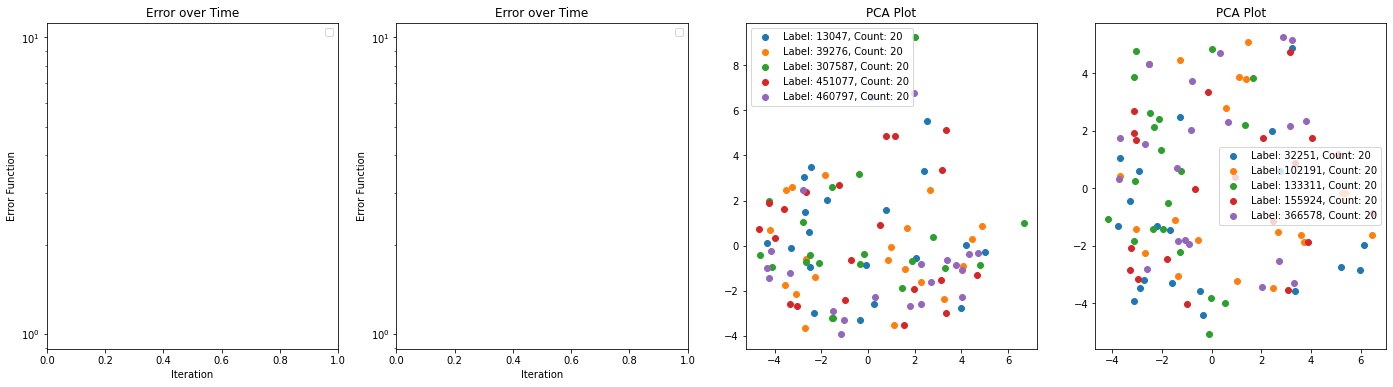

In [41]:
model.cpu()
plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1)
plot_training(history_cb.history, prefix='train_')
plt.subplot(1, 4, 2)
plot_training(history_cb.history, prefix='val_')
plt.subplot(1, 4, 3)
plot_embeddings(model, sample_dataloader.train_dataset)
plt.subplot(1, 4, 4)
plot_embeddings(model, sample_dataloader.val_dataset)
# plt.figure(figsize=(24, 9))
# dataset = sample_dataloader.val_dataset
# dataset = dataset[equal_samples_labels_images(dataset.labels, instances=8)]
# plot_sample_images(dataset, dim=(3, 8))